# **Experiment Notebook**



## Context


### 0. Import Packages

In [63]:
! pip install -r https://raw.githubusercontent.com/aso-uts/labs_datasets/main/36106-mlaa/requirements.txt

In [64]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os


from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

### 1.   Load Dataset

In [65]:
path = os.getcwd()
all_files = glob.glob(path + "/*.csv")
del all_files[0]
customers = pd.read_csv('customers.csv', delimiter='|')

In [66]:
df_list = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0,  delimiter='|', on_bad_lines='skip')
    
    base = os.path.basename(filename)  #
    transaction_id = int(base.split('_')[-1].split('.')[0]) 
    df['transaction_id'] = transaction_id  
    
    df_list.append(df)
    

df_list = [df.dropna(axis=1, how='all') for df in df_list]

transactions= pd.concat(df_list, axis=0, ignore_index=True)

In [67]:
transactions.shape

(4260904, 11)

In [68]:
transactions.head(1)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,transaction_id
0,4218196001337,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522,0


In [69]:
customers.head(1)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03,888022315787


In [70]:
df_final = transactions.merge(customers.drop('acct_num', axis=1), on='cc_num')

In [71]:
df_final.head(2)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,transaction_id,ssn,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,4218196001337,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522,0,115-04-4507,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
1,4218196001337,888022315787,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359,0,115-04-4507,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03


### 2. Explore Dataset

In [72]:
df_final['unix_time'] = pd.to_datetime(df_final['unix_time'], unit='s')

<Axes: xlabel='Count', ylabel='unix_time'>

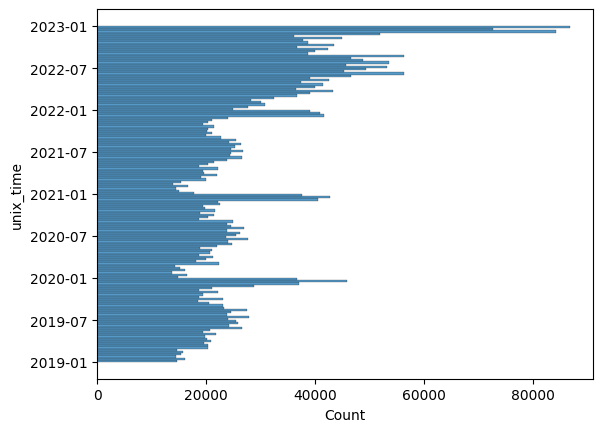

In [73]:
sns.histplot(data=df_final, y=df_final.unix_time)

There are many datapoints, to avoid computer power problems, the dataset will be filtered

In [74]:
max_date = '2022-06-01'

In [75]:
max_date = '2022-06-01'
df = df_final[(df_final['unix_time'] >= max_date)].reset_index(drop=True).copy(deep = True)
df.shape

(1117411, 24)

<Axes: xlabel='Count', ylabel='unix_time'>

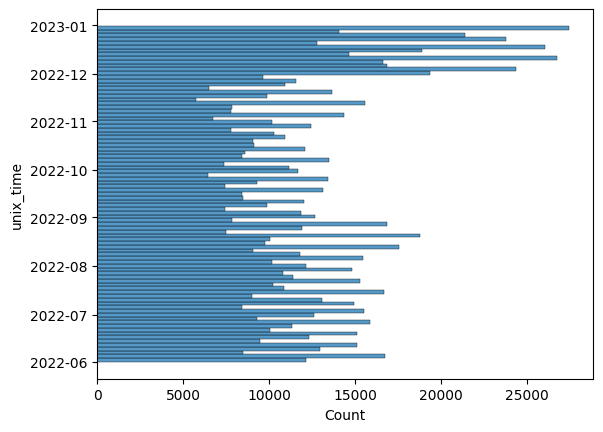

In [76]:
sns.histplot(data=df, y=df.unix_time)

In [77]:
df.isnull().sum()

cc_num            0
acct_num          0
trans_num         0
unix_time         0
category          0
amt               0
is_fraud          0
merchant          0
merch_lat         0
merch_long        0
transaction_id    0
ssn               0
first             0
last              0
gender            0
street            0
city              0
state             0
zip               0
lat               0
long              0
city_pop          0
job               0
dob               0
dtype: int64

no null data

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117411 entries, 0 to 1117410
Data columns (total 24 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   cc_num          1117411 non-null  int64         
 1   acct_num        1117411 non-null  int64         
 2   trans_num       1117411 non-null  object        
 3   unix_time       1117411 non-null  datetime64[ns]
 4   category        1117411 non-null  object        
 5   amt             1117411 non-null  float64       
 6   is_fraud        1117411 non-null  int64         
 7   merchant        1117411 non-null  object        
 8   merch_lat       1117411 non-null  float64       
 9   merch_long      1117411 non-null  float64       
 10  transaction_id  1117411 non-null  int64         
 11  ssn             1117411 non-null  object        
 12  first           1117411 non-null  object        
 13  last            1117411 non-null  object        
 14  gender          11

Extract the age from the dob column

In [79]:
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = df['dob'].apply(lambda x: datetime.datetime.now().year - x.year - ((datetime.datetime.now().month, datetime.datetime.now().day) < (x.month, x.day)))

Try to group the job by categories

In [80]:
occupations = {
    'Accounting/Finance': ['Accountant, Chartered', 'Accountant, Chartered Management', 'Chartered Accountant', 'Chief Financial Officer', 'Financial Trader', 'Investment Banker, Operational', 'Financial Risk Analyst', 'Pensions Consultant', 'Tax Adviser'],
    'Education/Teaching': ['Lecturer, Further Education', 'Teacher, Adult Education', 'Teacher, Early Years/Pre', 'Teacher, English as a Foreign Language', 'Teacher, Music', 'Teacher, Primary School', 'Teacher, Secondary School', 'Teacher, Special Educational Needs', 'Teacher, Secondary School'],
    'Healthcare/Medical': ['Acupuncturist', 'Anaesthetist', 'Chiropodist', 'Dentist', 'Dietitian', 'Doctor, Hospital', 'Haematologist', 'Midwife', 'Neurosurgeon', 'Nurse, Adult', 'Nurse, Children\'s', 'Nurse, Learning Disability', 'Nurse, Mental Health', 'Occupational Therapist', 'Oncologist', 'Ophthalmologist', 'Orthoptist', 'Paediatric Nurse', 'Paramedic', 'Pathologist', 'Physiotherapist', 'Psychiatrist', 'Radiation Protection Practitioner', 'Radiographer, Diagnostic', 'Radiographer, Therapeutic', 'Surgeon', 'Clinical Scientist, Histocompatibility and Immunogenetics', 'Clinical Biochemist', 'Clinical Cytogeneticist', 'Clinical Embryologist', 'Clinical Molecular Geneticist', 'Clinical Psychologist', 'Clinical Research Associate', 'Mental Health Nurse', 'Physiological Scientist', 'Public Health Specialist', 'Medical Laboratory Scientific Officer'],
    'Information Technology/Computer Science': ['Applications Developer', 'Data Scientist', 'IT Consultant', 'IT Sales Professional', 'Network Engineer', 'Software Engineer', 'Systems Analyst', 'Systems Developer', 'Technical Author'],
    'Engineering/Technical': ['Aeronautical Engineer', 'Agricultural Engineer', 'Automotive Engineer', 'Chemical Engineer', 'Civil Engineer', 'Drilling Engineer', 'Electrical Engineer', 'Electronics Engineer', 'Energy Engineer', 'Environmental Engineer', 'Geologist, Engineering', 'Geographical Information Systems Officer', 'Hydrogeologist', 'Materials Engineer', 'Mechanical Engineer', 'Mining Engineer', 'Petroleum Engineer', 'Structural Engineer', 'Water Engineer'],
    'Legal': ['Barrister\'s Clerk', 'Legal Executive', 'Lawyer', 'Legal Secretary', 'Solicitor'],
    'Creative/Artistic': ['Actor', 'Animator', 'Art Gallery Manager', 'Art Therapist', 'Artist', 'Ceramics Designer', 'Composer', 'Conservator, Furniture', 'Copywriter, Advertising', 'Designer, Exhibition/Display', 'Designer, Fashion/Clothing', 'Designer, Furniture', 'Designer, Graphic', 'Designer, Industrial/Product', 'Designer, Interior/Spatial', 'Designer, Jewellery', 'Designer, Multimedia', 'Designer, Textile', 'Designer, Television/Film Set', 'Director, Theatre', 'Editorial Assistant', 'Fashion Designer', 'Fine Artist', 'Illustrator', 'Interior and Spatial Designer', 'Jewellery Designer', 'Make-Up Artist', 'Musician', 'Playwright', 'Poet', 'Printmaker', 'Proofreader', 'Set Designer', 'Stage Manager', 'Theatre Director', 'Visual Merchandiser', 'Writer'],
    'Business/Management/Administration': ['Administrator', 'Administrator, Arts', 'Administrator, Charities/Voluntary Organizations', 'Administrator, Civil Service', 'Administrator, Education', 'Advertising Account Executive', 'Advertising Account Planner', 'Advertising Art Director', 'Advertising Copywriter', 'Applications Developer', 'Business Analyst', 'Business Development Manager', 'Business Intelligence Analyst', 'Business Manager', 'Cabin Crew', 'Call Centre Manager', 'Catering Manager', 'Chief Executive Officer', 'Chief Marketing Officer', 'Chief of Staff', 'Company Secretary', 'Compliance Officer', 'Contractor', 'Customer Service Manager', 'Data Processing Manager', 'Facilities Manager', 'Health Service Manager', 'Hotel Manager', 'Housing Manager/Officer', 'Human Resources Officer', 'Information Officer', 'Insurance Account Manager', 'Insurance Broker', 'Intelligence Analyst', 'Interpreter', 'IT Trainer', 'Land/Property Manager', 'Landlord/Tenant Manager', 'Lobbyist', 'Loss Adjuster, Chartered', 'Management Consultant', 'Market Researcher', 'Marketing Executive', 'Office Manager', 'Operations Manager', 'Product Manager', 'Project Manager', 'Purchasing Manager', 'Quality Manager', 'Recruitment Consultant', 'Relationship Manager', 'Sales Executive', 'Sales Promotion Account Executive', 'Sales Professional, IT', 'Sales Support Administrator', 'Stockbroker', 'Supply Chain Manager', 'Systems Developer', 'Tax Adviser', 'Technical Sales Engineer', 'Tour Manager', 'Tourism Officer', 'Trade Union Research Officer', 'Translator', 'Warehouse Manager'],
    'Research/Science': ['Archaeologist', 'Astronomer', 'Biologist', 'Botanist', 'Chemist', 'Clinical Research Associate', 'Data Scientist', 'Ecologist', 'Environmental Consultant', 'Geneticist', 'Marine Scientist', 'Mathematician', 'Meteorologist', 'Microbiologist', 'Oceanographer', 'Physicist', 'Research Scientist', 'Scientist', 'Statistician', 'Zoologist'],
    'Social Services/Community Development': ['Community Arts Worker', 'Community Development Worker', 'Counsellor', 'Guidance Worker', 'Social Worker', 'Support Worker', 'Youth Worker'],
    'Retail/Hospitality': ['Barista', 'Brewer', 'Butcher', 'Caterer', 'Chef', 'Food Technologist', 'Hotel Manager', 'Publican', 'Restaurant Manager', 'Retail Buyer', 'Retail Manager', 'Sommelier'],
    'Others': ['Armed Forces Officer', 'Diplomat', 'Emergency Services Worker', 'Funeral Director', 'Local Government Officer', 'Member of Parliament (MP)', 'Public Servant', 'Religious Leader', 'Security Guard', 'Socialite', 'Taxi Driver', 'Waiter/Waitress']
}


job_to_category = {job: category for category, jobs in occupations.items() for job in jobs}


In [81]:
def map_job_to_category(job):
    return job_to_category.get(job, "Other")

df['job_category'] = df['job'].apply(map_job_to_category)

In [82]:
df.job_category.value_counts()

job_category
Other                                    1027514
Healthcare/Medical                         29104
Business/Management/Administration         18378
Research/Science                           13338
Creative/Artistic                          12323
Accounting/Finance                          5984
Legal                                       3771
Retail/Hospitality                          2892
Engineering/Technical                       2189
Social Services/Community Development       1918
Name: count, dtype: int64

Still many data without any category, this could work for a future improvement

<Figure size 1000x600 with 0 Axes>

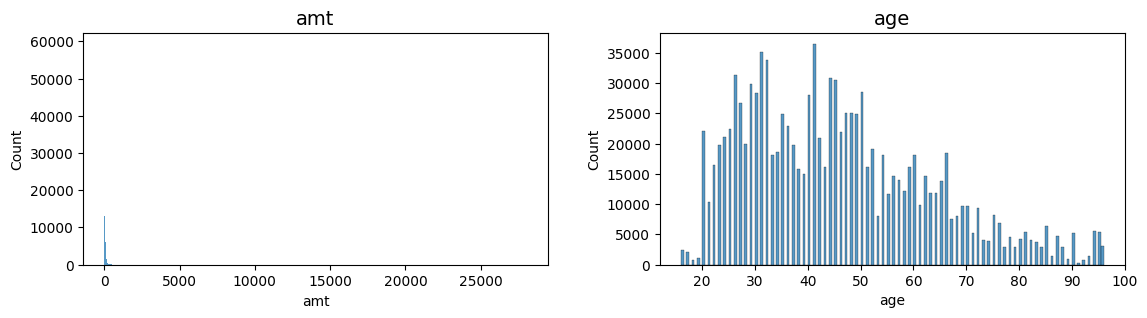

In [83]:
df_numeric = df[['amt', 'age']]

plt.figure(figsize=(10, 6))

n_rows = len(df_numeric.columns) // 3 + (len(df_numeric.columns) % 3 > 0)
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
fig.tight_layout(pad=5.0)

axs = axs.reshape(-1)

for i, col in enumerate(df_numeric.columns):
    bin_width = 2 * (np.percentile(df_numeric[col], 75) - np.percentile(df_numeric[col], 25)) / (len(df_numeric[col]) ** (1/3))
    num_bins = int(np.ceil((df_numeric[col].max() - df_numeric[col].min()) / bin_width))

    sns.histplot(df_numeric[col], ax=axs[i], bins=num_bins, kde=False)
    axs[i].set_title(col, fontsize=14)

for j in range(i+1, n_rows*n_cols):
    axs[j].set_visible(False)

plt.show()

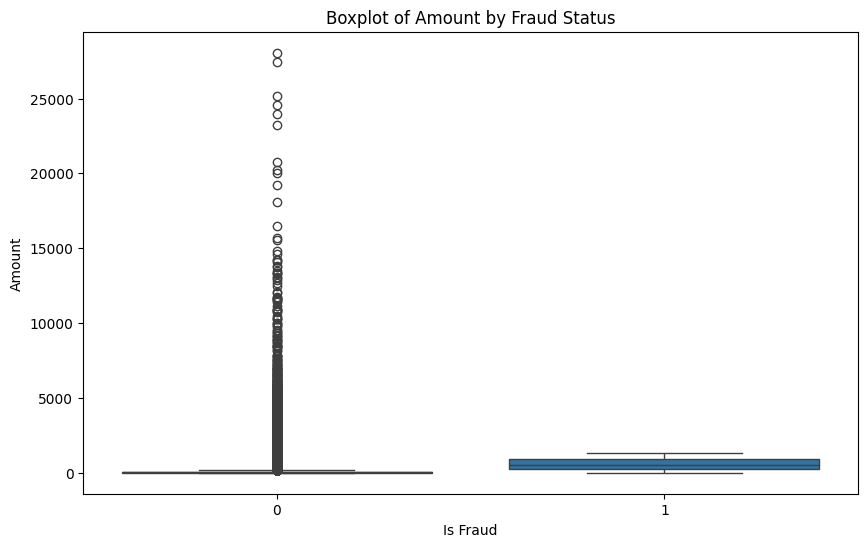

In [84]:
plt.figure(figsize=(10, 6))


sns.boxplot(data=df, x='is_fraud', y='amt')

plt.xlabel('Is Fraud')
plt.ylabel('Amount')
plt.title('Boxplot of Amount by Fraud Status')

plt.show()

The boxplot shows that fraud transaction are not higher than 3000 aprox, also it seems to have a normal distribution

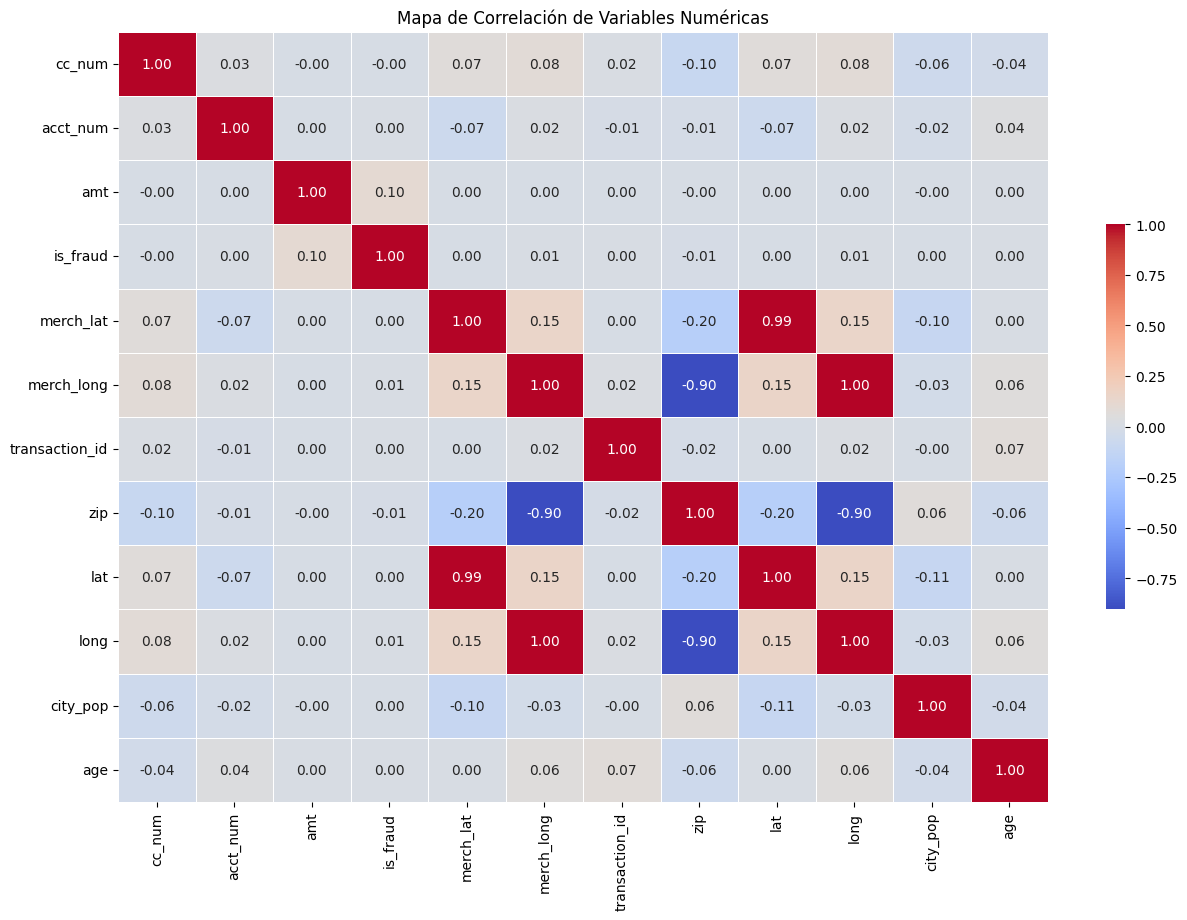

In [85]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Mapa de Correlación de Variables Numéricas')
plt.show()

No important correlation founded

Drop useless columns

In [86]:
df.drop(columns=['ssn','first', 'last', 'street','lat','long','city_pop','dob','merch_lat', 'merch_long'], inplace = True)



extract temporal data form the unix_time

In [87]:
df['hour'] = df['unix_time'].dt.hour
df['day_of_week'] = df['unix_time'].dt.weekday
df['month'] = df['unix_time'].dt.month

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117411 entries, 0 to 1117410
Data columns (total 19 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   cc_num          1117411 non-null  int64         
 1   acct_num        1117411 non-null  int64         
 2   trans_num       1117411 non-null  object        
 3   unix_time       1117411 non-null  datetime64[ns]
 4   category        1117411 non-null  object        
 5   amt             1117411 non-null  float64       
 6   is_fraud        1117411 non-null  int64         
 7   merchant        1117411 non-null  object        
 8   transaction_id  1117411 non-null  int64         
 9   gender          1117411 non-null  object        
 10  city            1117411 non-null  object        
 11  state           1117411 non-null  object        
 12  zip             1117411 non-null  int64         
 13  job             1117411 non-null  object        
 14  age             11

In [89]:
df.sort_values(by=['acct_num', 'unix_time'], inplace=True)

Calculate the time before the last transaction in seconds for each account, this variable could potentially help the model

In [90]:
df['time_since_last_transaction'] = df.groupby('acct_num')['unix_time'].diff()
df['time_since_last_transaction'] = df['time_since_last_transaction'].dt.total_seconds()

In [91]:
df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(0)

In [92]:
df

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,transaction_id,gender,city,state,zip,job,age,job_category,hour,day_of_week,month,time_since_last_transaction
337843,6011534281644163,2348758451,2496aad4ec3443e8366c757298e213df,2022-06-01 03:38:23,home,22.34,0,"Perez, Young and Espinoza",116,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,3,2,6,0.0
338028,6011534281644163,2348758451,e7758ac8375822be1441272e6a2cb2d8,2022-06-01 07:22:36,home,233.97,0,Phelps-Perry,116,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,7,2,6,13453.0
338511,6011534281644163,2348758451,153375aee2a28a025b084e017783c12c,2022-06-01 07:54:33,misc_pos,5.45,0,Smith-Jacobs,39,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,7,2,6,1917.0
338802,6011534281644163,2348758451,76c253767a77c8669fd9b0936dd089ce,2022-06-01 09:40:33,misc_pos,4.64,0,Marquez-Torres,39,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,9,2,6,6360.0
338512,6011534281644163,2348758451,20aa44c422e9d563565e8499a7c7623a,2022-06-01 10:52:02,misc_pos,44.20,0,Moore-Campbell,39,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,10,2,6,4289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925085,180036374545891,999389892260,b06e79bf90cf14f1d0b5d75201d2a3f1,2022-12-31 09:17:37,travel,89.17,0,"Anderson, White and Newman",5,M,De Soto,MO,63020,Phytotherapist,36,Other,9,5,12,818.0
925394,180036374545891,999389892260,6d78511f4b4d74c20161552998c86f1b,2022-12-31 09:33:09,travel,92.92,0,"Garner, Bush and Villa",5,M,De Soto,MO,63020,Phytotherapist,36,Other,9,5,12,932.0
924655,180036374545891,999389892260,5bc94736afa845c26762d923ee58b7dc,2022-12-31 10:12:38,travel,9.03,0,Reed Inc,5,M,De Soto,MO,63020,Phytotherapist,36,Other,10,5,12,2369.0
925668,180036374545891,999389892260,d1440fcda7f43df7152f5fc70a8795a8,2022-12-31 10:50:54,travel,27.67,0,"Harris, Smith and King",94,M,De Soto,MO,63020,Phytotherapist,36,Other,10,5,12,2296.0


In [93]:
threshold = 100
len(df_final[df_final.amt>threshold])

746917

### 3. Explore Target variable

No target variable

### 4. Explore Variables of Interest

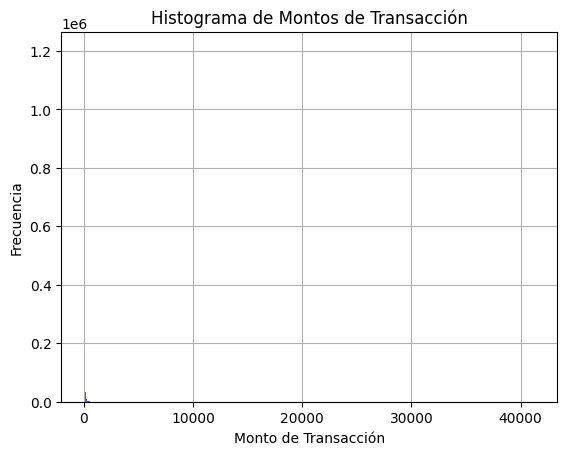

In [94]:
plt.hist(df_final['amt'], bins=range(int(df_final['amt'].min()), int(df_final['amt'].max()) + 10, 10), color='blue', alpha=0.7)
plt.title('Histograma de Montos de Transacción')
plt.xlabel('Monto de Transacción')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()



to visualize better this variable, I used a log transformation

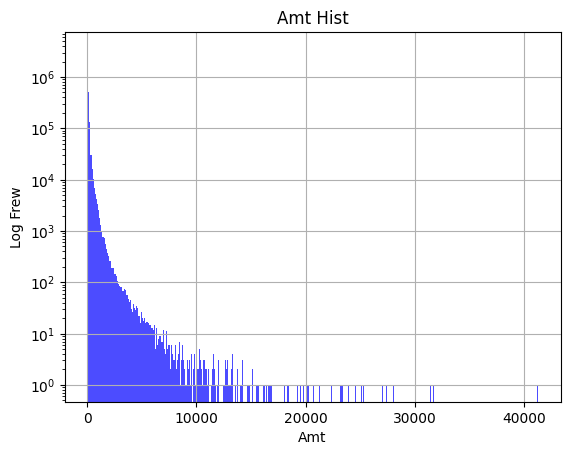

In [95]:
plt.hist(df_final['amt'], bins=range(int(df_final['amt'].min()), int(df_final['amt'].max()) + 100, 100), color='blue', alpha=0.7)
plt.yscale('log')  
plt.title('Amt Hist')
plt.xlabel('Amt')
plt.ylabel('Log Frew')
plt.grid(True)
plt.show()


<Axes: xlabel='time_since_last_transaction', ylabel='Count'>

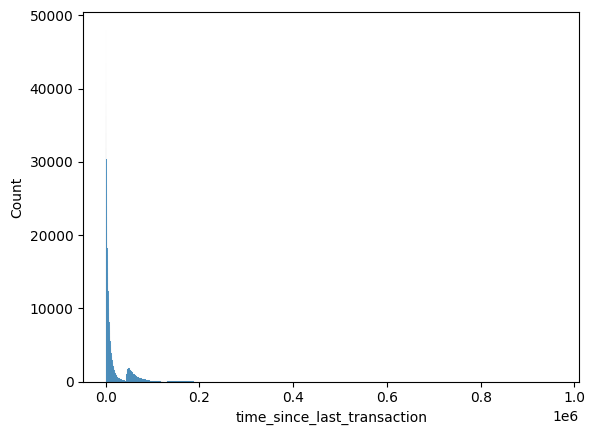

In [96]:
sns.histplot(df.time_since_last_transaction)

In [97]:
df

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,transaction_id,gender,city,state,zip,job,age,job_category,hour,day_of_week,month,time_since_last_transaction
337843,6011534281644163,2348758451,2496aad4ec3443e8366c757298e213df,2022-06-01 03:38:23,home,22.34,0,"Perez, Young and Espinoza",116,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,3,2,6,0.0
338028,6011534281644163,2348758451,e7758ac8375822be1441272e6a2cb2d8,2022-06-01 07:22:36,home,233.97,0,Phelps-Perry,116,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,7,2,6,13453.0
338511,6011534281644163,2348758451,153375aee2a28a025b084e017783c12c,2022-06-01 07:54:33,misc_pos,5.45,0,Smith-Jacobs,39,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,7,2,6,1917.0
338802,6011534281644163,2348758451,76c253767a77c8669fd9b0936dd089ce,2022-06-01 09:40:33,misc_pos,4.64,0,Marquez-Torres,39,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,9,2,6,6360.0
338512,6011534281644163,2348758451,20aa44c422e9d563565e8499a7c7623a,2022-06-01 10:52:02,misc_pos,44.20,0,Moore-Campbell,39,M,Rochester,NY,14621,"Surveyor, minerals",47,Other,10,2,6,4289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925085,180036374545891,999389892260,b06e79bf90cf14f1d0b5d75201d2a3f1,2022-12-31 09:17:37,travel,89.17,0,"Anderson, White and Newman",5,M,De Soto,MO,63020,Phytotherapist,36,Other,9,5,12,818.0
925394,180036374545891,999389892260,6d78511f4b4d74c20161552998c86f1b,2022-12-31 09:33:09,travel,92.92,0,"Garner, Bush and Villa",5,M,De Soto,MO,63020,Phytotherapist,36,Other,9,5,12,932.0
924655,180036374545891,999389892260,5bc94736afa845c26762d923ee58b7dc,2022-12-31 10:12:38,travel,9.03,0,Reed Inc,5,M,De Soto,MO,63020,Phytotherapist,36,Other,10,5,12,2369.0
925668,180036374545891,999389892260,d1440fcda7f43df7152f5fc70a8795a8,2022-12-31 10:50:54,travel,27.67,0,"Harris, Smith and King",94,M,De Soto,MO,63020,Phytotherapist,36,Other,10,5,12,2296.0


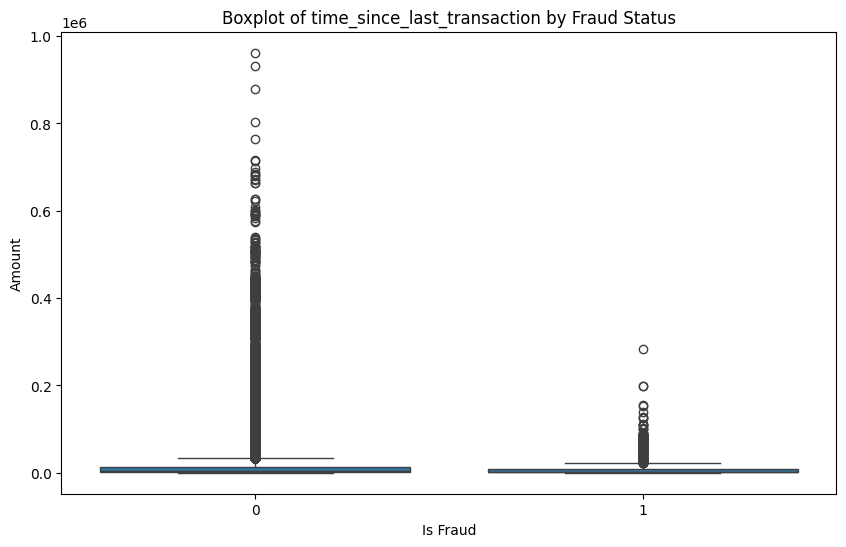

In [98]:
plt.figure(figsize=(10, 6))


sns.boxplot(data=df, x='is_fraud', y='time_since_last_transaction')

plt.xlabel('Is Fraud')
plt.ylabel('Amount')
plt.title('Boxplot of time_since_last_transaction by Fraud Status')

plt.show()

### 5. Prepare Data

In [402]:
def clean_and_preprocess_df(df_treated):
    df_processing = df_treated.copy(deep=True)
    df_processing['unix_time'] = pd.to_datetime(df_processing['unix_time'], unit='s')
    max_date = '2022-06-01'
    df_processing = df_processing[(df_processing['unix_time'] >= max_date)].reset_index(drop=True)

    df_processing['dob'] = pd.to_datetime(df_processing['dob'])
    

    df_processing['hour'] = df_processing['unix_time'].dt.hour
    df_processing['day_of_week'] = df_processing['unix_time'].dt.weekday
    df_processing['month'] = df_processing['unix_time'].dt.month

    df_processing.sort_values(by=['acct_num', 'unix_time'], inplace=True)
    df_processing['time_since_last_transaction'] = df_processing.groupby('acct_num')['unix_time'].diff()
    df_processing['time_since_last_transaction'] = df_processing['time_since_last_transaction'].dt.total_seconds()
    df_processing['time_since_last_transaction'] = df_processing['time_since_last_transaction'].fillna(999999)


    df_processing['past_week_transactions'] = df_processing.groupby('acct_num').apply(
        lambda x: x.set_index('unix_time').rolling('7D').amt.count()
    ).reset_index(drop=True)

    df_processing['past_month_transactions_average'] = df_processing.groupby('acct_num').apply(
        lambda x: x.set_index('unix_time').rolling('30D').amt.mean()
    ).reset_index(drop=True)

    df_processing.drop(columns=['cc_num','gender','zip','city', 'state', 'transaction_id', 'merchant', 'job', 'trans_num', 'acct_num', 'ssn', 'first', 'last', 'street', 'lat', 'long', 'city_pop', 'dob', 'is_fraud', 'merch_lat', 'merch_long', 'unix_time'], inplace=True)

    threshold = 200
    df_processing = df_processing[df_processing['amt'] > threshold].reset_index(drop=True)

    numeric_data = df_processing.select_dtypes(include=['float64', 'int64'])

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_data)
    scaled_numeric_data = pd.DataFrame(scaled_data, columns=numeric_data.columns)
    df_processing[numeric_data.columns] = scaled_numeric_data

    le = LabelEncoder()
    for col in df_processing.columns:
        if df_processing[col].dtype == 'object':
            df_processing[col] = le.fit_transform(df_processing[col])

    return df_processing



In [403]:
test = clean_and_preprocess_df(df_final)

In [404]:
test

,category,amt,hour,day_of_week,month,time_since_last_transaction,past_week_transactions,past_month_transactions_average
0,6,-0.348780,7,2,6,-0.043078,-0.855811,0.429058
1,9,-0.357869,10,3,6,-0.274446,-1.234741,0.223583
2,6,-0.303588,12,6,6,-0.258428,1.417771,-0.684485
3,6,0.435761,2,4,6,1.004594,1.683023,-0.744008
4,9,0.175041,11,5,6,-0.379844,-1.045276,-0.441248
...,...,...,...,...,...,...,...,...
48223,13,-0.186882,1,4,12,-0.376128,-0.249522,-0.515419
48224,10,0.267275,1,6,12,-0.385026,-1.234741,-0.405047
48225,13,-0.144058,9,2,12,-0.214301,-0.363201,0.059451
48226,13,-0.392988,11,3,12,-0.304205,0.015729,-0.047428


### 8. Train Machine Learning Model

In [405]:
X = test.copy(deep=True)

In [406]:
iso_forest = IsolationForest(n_estimators=300, max_samples='auto', random_state=42)
iso_forest.fit(X)
predictions = iso_forest.predict(X)
scores = iso_forest.decision_function(X)  

test['scores'] = scores
test['anomaly'] = predictions

In [411]:
test.head(5)

,category,amt,hour,day_of_week,month,time_since_last_transaction,past_week_transactions,past_month_transactions_average,scores,anomaly
0,6,-0.348780,7,2,6,-0.043078,-0.855811,0.429058,0.055576,1
1,9,-0.357869,10,3,6,-0.274446,-1.234741,0.223583,0.062477,1
2,6,-0.303588,12,6,6,-0.258428,1.417771,-0.684485,0.031389,1
3,6,0.435761,2,4,6,1.004594,1.683023,-0.744008,-0.018278,-1
4,9,0.175041,11,5,6,-0.379844,-1.045276,-0.441248,0.061003,1


### 9. Assess Model Performance

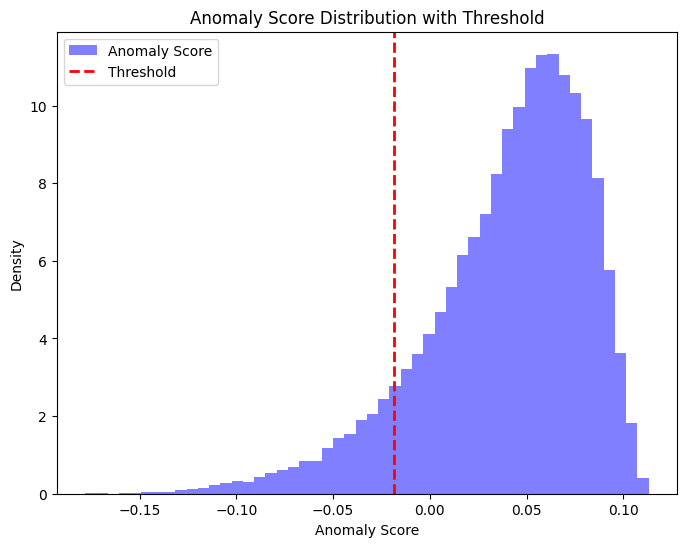

In [412]:
threshold = np.percentile(scores, 100 * 0.1)  

plt.figure(figsize=(8, 6))
plt.hist(scores, bins=50, density=True, alpha=0.5, color='blue', label='Anomaly Score')
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Anomaly Score Distribution with Threshold')
plt.legend()
plt.show()

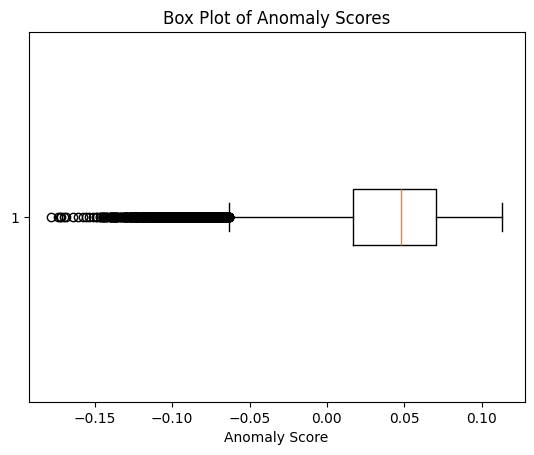

In [413]:
plt.boxplot(test['scores'], vert=False)
plt.title('Box Plot of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.show()

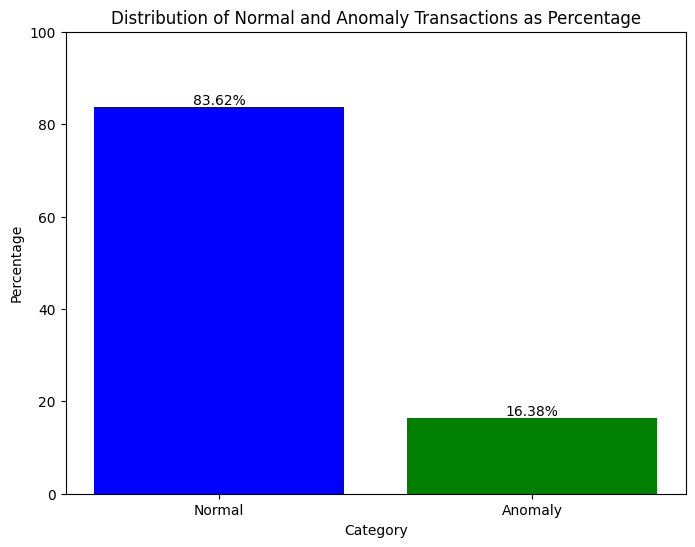

In [414]:
normal_count = (test['anomaly'] == 1).sum()
anomaly_count = (test['anomaly'] == -1).sum()

total = len(test['anomaly'])

normal_percentage = (normal_count / total) * 100
anomaly_percentage = (anomaly_count / total) * 100

categories = ['Normal', 'Anomaly']
percentages = [normal_percentage, anomaly_percentage]

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, percentages, color=['blue', 'green'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')

plt.title('Distribution of Normal and Anomaly Transactions as Percentage')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.ylim(0, 100)  

plt.show()

In [415]:
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
labels = iso_forest.fit_predict(X)

tsne_results = tsne.fit_transform(X)

tsne_df = pd.DataFrame({
    'tsne1': tsne_results[:, 0],
    'tsne2': tsne_results[:, 1],
    'label': labels
})

colors = {1: 'blue', -1: 'green'}

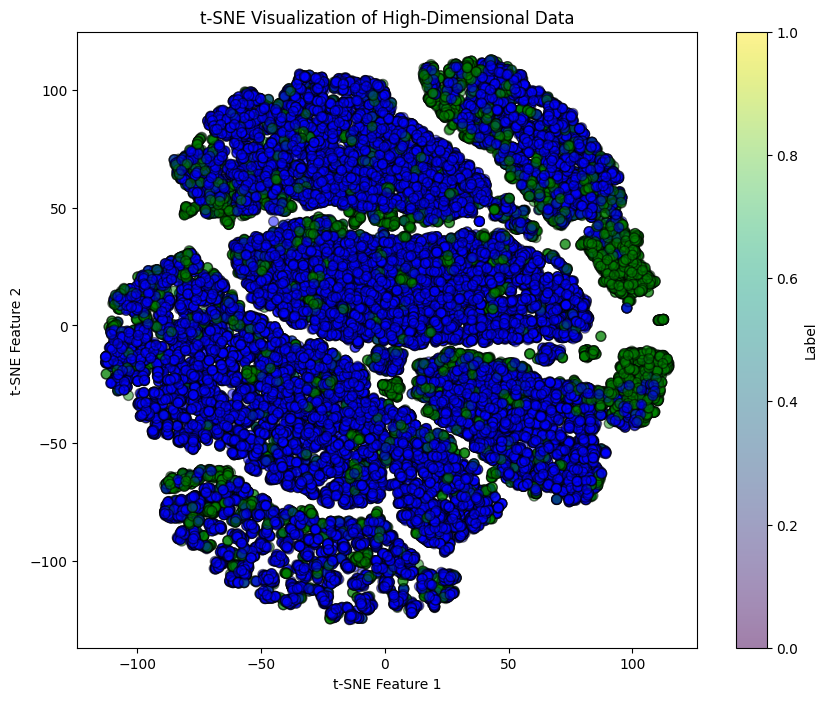

In [416]:
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['tsne1'], tsne_df['tsne2'], c=tsne_df['label'].map(colors), alpha=0.5, edgecolor='k', s=50)
plt.colorbar(label='Label')
plt.title('t-SNE Visualization of High-Dimensional Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()